In [ ]:
%pip install git+https://github.com/samoturk/mol2vec -q
%pip install 'polars[numpy,pandas,pyarrow]' -q
%pip install rdkit -q
%pip install matplotlib -q
%pip install gdown -q
%pip install scikit_learn -q
%pip install lazypredict_nightly -q
%pip install transformers -q
%pip install ipywidgets -q
%pip install torch_geometric -q

!gdown 1CggX5LuLQ2nRA96SgzMYF3m4Ma7kj1ri -O models/model_300dim.pkl

In [5]:
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt

from typing import Optional

from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


def read(n: str, **kwargs):
    return pl.read_csv(f"../data/{n}", **kwargs).to_pandas()


# data = read("smiles/data.csv")
data = read("params/data.csv")
check = read("params/check.csv")

# ============================================================================ #
# Fix gensim error
# https://github.com/piskvorky/gensim/commit/ad68ee3f105fc37cf8db333bfb837fe889ff74ac
# ============================================================================ #

In [16]:
scaler = StandardScaler()
selector = SelectKBest(score_func=f_regression, k=100)


def preprocess(
    data: pd.DataFrame, preprocessor: Optional[ColumnTransformer] = None
) -> tuple[pd.DataFrame, Optional[pd.DataFrame], ColumnTransformer]:
    data = data.copy()
    data = data.loc[
        (
            data["oil_property_param_title"]
            == "ad7e6027-00b8-4c27-918c-d1561f949ad8"
        )
    ]
    data.reset_index(drop=True, inplace=True)
    data = data.dropna()

    def compute_descriptors(smiles: str):
        RDLogger.DisableLog("rdApp.*")
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        # morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        # morgan_fp_bits = list(morgan_fp.ToBitString())

        features = {
            "MolWt": Descriptors.MolWt(mol),
            "MolLogP": Descriptors.MolLogP(mol),
            "NumAtoms": mol.GetNumAtoms(),
            "NumHeavyAtoms": mol.GetNumHeavyAtoms(),
            "NumHeteroatoms": Descriptors.NumHeteroatoms(mol),
            # "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
            # "NumAromaticRings": Descriptors.NumAromaticRings(mol),
            # "NumSaturatedRings": Descriptors.NumSaturatedRings(mol),
            # "NumAliphaticRings": Descriptors.NumAliphaticRings(mol),
            # "RingCount": Descriptors.RingCount(mol),
            # "TPSA": Descriptors.TPSA(mol),
            # "LabuteASA": Descriptors.LabuteASA(mol),
            # "BalabanJ": Descriptors.BalabanJ(mol),
            # "BertzCT": Descriptors.BertzCT(mol),
            # "Chi0": Descriptors.Chi0(mol),
            # "Chi1": Descriptors.Chi1(mol),
            # "Chi0n": Descriptors.Chi0n(mol),
            # "Chi1n": Descriptors.Chi1n(mol),
            # "Chi2n": Descriptors.Chi2n(mol),
            # "Chi3n": Descriptors.Chi3n(mol),
            # "Chi4n": Descriptors.Chi4n(mol),
            # "HallKierAlpha": Descriptors.HallKierAlpha(mol),
            # "Kappa1": Descriptors.Kappa1(mol),
            # "Kappa2": Descriptors.Kappa2(mol),
            # "Kappa3": Descriptors.Kappa3(mol),
        }

        # for i, bit in enumerate(morgan_fp_bits):
        #     features[f"Bit_{i}"] = bit

        return features

    descriptors_df = pd.DataFrame.from_records(
        data["smiles"].apply(compute_descriptors).dropna().tolist()
    )
    data = pd.concat([descriptors_df, data], axis=1)
    data = data.drop("smiles", axis=1)

    if "blend_id" in data.columns:
        data = data.drop("blend_id", axis=1)

    if "polymer" in data.columns:
        data["polymer"] = data["polymer"].map({"no": 0, "yes": 1})

    data = data.dropna()
    categorical_cols = data.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()

    if preprocessor is None:
        categorical_transformer = Pipeline(
            steps=[
                (
                    "imputer",
                    SimpleImputer(strategy="constant", fill_value="missing"),
                ),
                ("onehot", OneHotEncoder(handle_unknown="ignore")),
            ]
        )
        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", categorical_transformer, categorical_cols),
            ],
            remainder="passthrough",
        )

        encoding_data = pd.DataFrame(
            preprocessor.fit_transform(data[categorical_cols]).toarray(),
            columns=preprocessor.get_feature_names_out(categorical_cols),
        )
        data = pd.concat([data, encoding_data], axis=1)
        data = data.drop(categorical_cols, axis=1)
    else:
        encoding_data = pd.DataFrame(
            preprocessor.transform(data[categorical_cols]).toarray(),
            columns=preprocessor.get_feature_names_out(categorical_cols),
        )
        data = pd.concat([data, encoding_data], axis=1)
        data = data.drop(categorical_cols, axis=1)

    data = data.dropna()
    if "oil_property_param_value" in data.columns:
        y = data.pop("oil_property_param_value")
        # data = scaler.fit_transform(data, y)
        # data = selector.fit_transform(data, y)
        return pd.DataFrame(data), pd.DataFrame(y), preprocessor

    # data = scaler.transform(data)
    # data = selector.transform(data)
    return pd.DataFrame(data), None, preprocessor


X, y, preprocessor = preprocess(data)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X.head(3)

,MolWt,MolLogP,NumAtoms,NumHeavyAtoms,NumHeteroatoms,polymer,component_property_param_value,cat__oil_type_3fa07e0a-415c-496d-b88b-557855cb3e77,cat__oil_type_60c1209c-8e77-467e-a01f-b6321801a260,cat__oil_type_c25411c1-0bec-41f3-8eee-81daaed2b890,cat__oil_type_c8de281b-54cc-454f-a47b-9b78fed139e4,cat__oil_property_param_title_ad7e6027-00b8-4c27-918c-d1561f949ad8,cat__component_name_02bbb0cf-07c7-4456-8634-e5aa3808d631,cat__component_name_0444c588-f816-4b9b-a6dc-f596b021d6e3,cat__component_name_06a4061e-92a7-4621-88dd-3eb2b94eda3d,cat__component_name_154513d4-1e43-4f33-bb5d-dd608f2cd01d,cat__component_name_17e17c86-79ee-4c3c-ab9e-beb38c32dc5d,cat__component_name_183b1274-f199-4d9f-bf3e-69a294894c95,cat__component_name_25f1fcd0-7a1c-448c-9def-6e48ee332f02,cat__component_name_2685d6e5-8194-4397-8856-5bdb5d343cc4,cat__component_name_2a2c6dd8-18b4-4cb3-bb17-e9b51efc1bb9,cat__component_name_374eefee-18f3-4381-b81f-73a4985fd788,cat__component_name_40b0d8f3-8b06-4737-8475-a4ce5bcb7152,cat__component_name_5011713b-7c70-465a-a9d2-8eff131ae671,cat__component_name_57c7889a-6485-4d83-9477-f4e0503e0a33,cat__component_name_615537f6-1f8f-4240-a5e9-8f7be344ecd3,cat__component_name_62d3bfae-a440-4be2-9477-c84b0a0688d3,cat__component_name_6314fabc-8e78-42be-87fb-948ba3bee8f9,cat__component_name_65b030fe-1a40-4e80-9cb0-66cd4e291dd3,cat__component_name_671b8c2c-fdad-499e-bd67-3c57bba429f1,cat__component_name_7015fb73-07b8-49ee-8812-2aa9d5a97b61,cat__component_name_778849ba-f6ff-4b54-b1a6-8af824b2cd37,cat__component_name_7a781ed4-999d-4e6b-b1f1-a07281f3c8da,cat__component_name_80993e83-af5d-450f-b674-1f9dfd552c96,cat__component_name_939c6667-06f6-494e-99c1-88249e11f094,cat__component_name_94c6da88-8acb-4198-84c5-4f20642d8605,cat__component_name_9a24ca1e-2385-4b57-9151-918ee1504684,cat__component_name_9c36fb63-d617-46a1-af81-037fc18eadf7,cat__component_name_a26c3c1b-fc44-446f-a4f8-e9de47cd9be2,cat__component_name_a6715883-185b-411b-a05c-cdbb0675d5cd,cat__component_name_abf252e5-fe01-4700-847e-fb782e22b50c,cat__component_name_b26322a8-b4fa-41cc-a755-757b41d22919,cat__component_name_b84237b9-d742-481b-a9df-c0f01b1997fa,cat__component_name_bf726dc6-c5b9-4d91-b71c-c51a23b451f6,cat__component_name_f1dc5ac0-67a9-4148-9274-8f0acbcd5df7,cat__component_class_базовое масло 1 гр,cat__component_class_базовое масло 2 гр,cat__component_class_базовое масло 3 гр,cat__component_class_базовое масло 4 гр,cat__component_class_базовое масло 5 гр,cat__component_class_депрессорная присадка,cat__component_class_загущающая присадка,cat__component_class_присадка,cat__component_property_param_title_009c5608-34ee-44ec-a294-a6252d691af3,cat__component_property_param_title_02236ee6-5eec-4368-a2e4-6f2e73fb0f96,cat__component_property_param_title_08db8d40-6b81-44ab-ab91-4b482ebc4187,cat__component_property_param_title_0bede6ba-5118-4a24-8c61-4df27f5746d7,cat__component_property_param_title_1a8ce77b-9eac-489d-b6fc-4d7df0b74092,cat__component_property_param_title_2511714c-ab50-4566-bc92-8e4095d87d01,cat__component_property_param_title_38b06d9a-bcf2-40de-8e1b-9c3988c42406,cat__component_property_param_title_3f7871a6-3ebc-4d7c-a5c4-3867820048e1,cat__component_property_param_title_594a3970-ec4a-48bb-bd37-c00e2ce90d83,cat__component_property_param_title_59fae799-21eb-4093-b36a-5a9dc69119f7,cat__component_property_param_title_733eb700-e7a9-45de-bc8e-3bb15b7f5852,cat__component_property_param_title_7eddcad3-d00a-47b8-837c-79a18ac868c3,cat__component_property_param_title_89b4c419-0082-4f0a-b411-81487c96b76c,cat__component_property_param_title_89bf1ac2-0a0b-4e3e-8a75-7b364c2d0558,cat__component_property_param_title_8b0f4e99-1666-48b5-a378-c87b80ed97a9,cat__component_property_param_title_908bf166-393a-4e90-93d8-5d7b9944d637,cat__component_property_param_title_9703e283-f529-4fdb-8d84-24413b2b4338,cat__component_property_param_title_99b4f14e-593a-400b-a294-fe040d0e8923,cat__component_property_param_title_9c983e26-64ad-4505-9c8a-8b7d65922e2c,cat__component_property_param_title_a59e9688-c5e5-4488-

In [17]:
X.shape

(1090, 82)

c:\Users\xpos587\scoop\apps\mambaforge\current\envs\oilcode\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


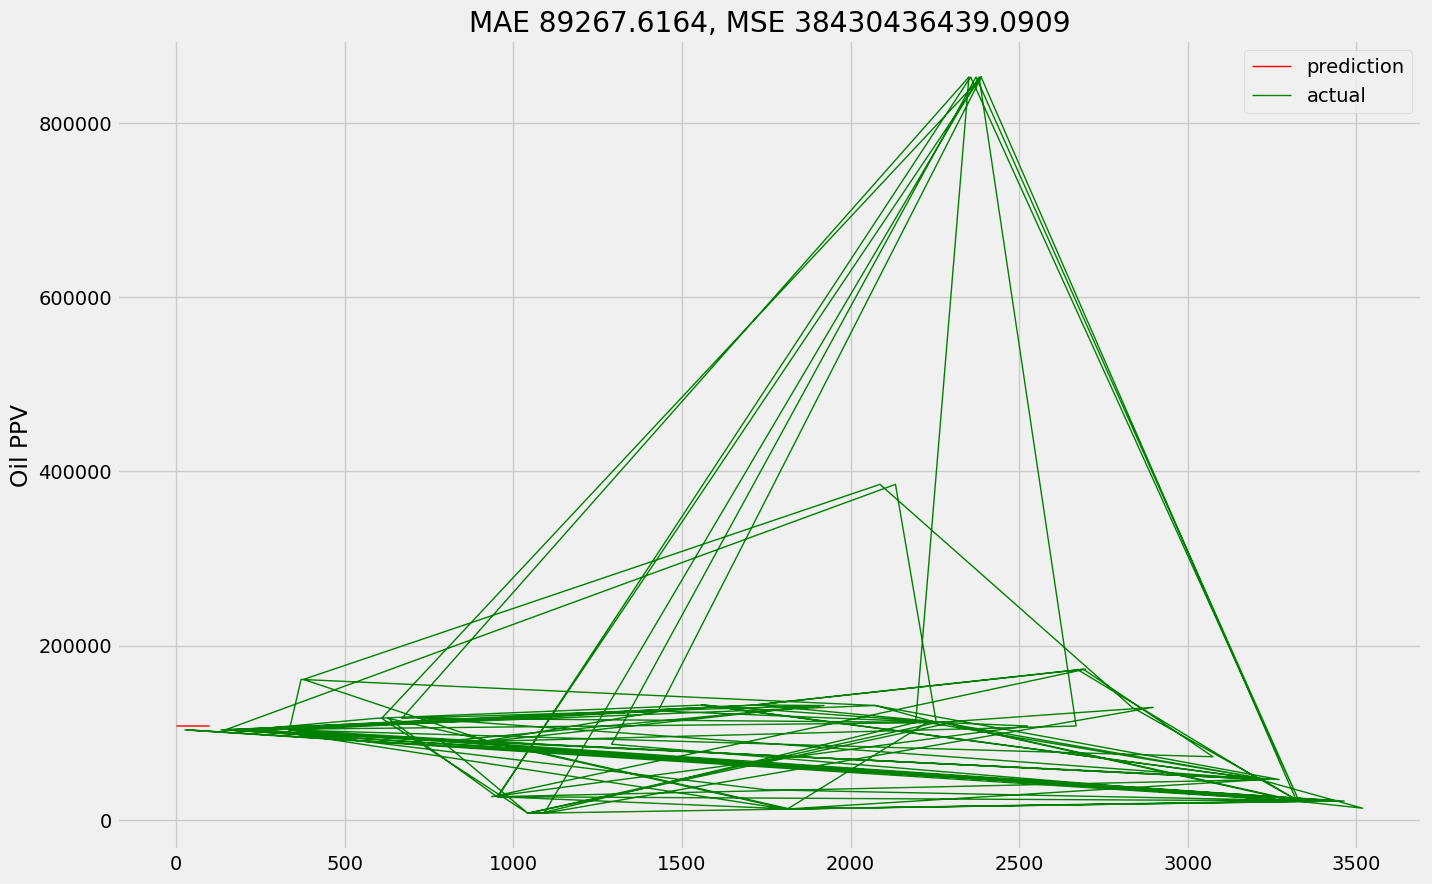

MAE score: 89267.6164
MSE score: 38430436439.0909


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR


def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction)

    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:100], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:100], "green", label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel("Oil PPV")
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()

    print("MAE score:", round(mae, 4))
    print("MSE score:", round(mse, 4))


oil_model = SVR()
oil_model.fit(X_train, y_train)
evaluation(oil_model, X_test, y_test)
# MAE score: 11121.1067

In [ ]:
X_check, _, _ = preprocess(check, preprocessor)

predictions = oil_model.predict(X_check)

In [ ]:
pd.DataFrame(predictions)

In [19]:
from sklearn.metrics import mean_absolute_error  # noqa: F811
from lazypredict import LazyRegressor

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

X_train = X_train.squeeze()
X_test = X_test.squeeze()
y_train = y_train.squeeze()
y_test = y_test.squeeze()

reg = LazyRegressor(predictions=True, custom_metric=mae)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)
models.sort_values(by="mae", ascending=True).head(5)

100%|██████████| 42/42 [00:07<00:00,  5.60it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 872, number of used features: 44
[LightGBM] [Info] Start training from score 132085,381881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,Adjusted R-Squared,R-Squared,RMSE,Time Taken,mae
Model,,,,,
PassiveAggressiveRegressor,-0.48,0.08,185648.71,0.18,86200.00
HuberRegressor,-0.49,0.07,186125.48,0.08,86850.28
SVR,-0.65,-0.03,196035.76,0.06,89266.52
QuantileRegressor,-0.65,-0.03,196036.58,0.11,89267.60
GammaRegressor,-0.39,0.13,180055.63,0.14,90879.09
